In [1]:
## ref: https://en.wikipedia.org/wiki/Travelling_salesman_problem
## Dantzig-Fulkerson-Johnson formulation
## Exact algorithms
## 

## Patrol Route Optimization

- Load data from the csv file.

In [2]:
import pandas as pd

crime = pd.read_csv('../data/crimeandweather.csv')
crime['OCCURRED_ON_DATE'] = pd.to_datetime(crime['OCCURRED_ON_DATE'])
crime['DATE'] = pd.to_datetime(crime['DATE'])
crime['Lat'] = pd.to_numeric(crime['Lat'])
crime['Long'] = pd.to_numeric(crime['Long'])
print("strat date:", crime['OCCURRED_ON_DATE'].min())
print("end date:", crime['OCCURRED_ON_DATE'].max())
crime.head()

strat date: 2015-06-15 00:00:00
end date: 2019-11-15 23:59:00


,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,OCCURRED_ON_DATE,DAY_OF_WEEK,Lat,Long,DATE,TIME,SNOW,TAVG
0,3005,NaN,SICK ASSIST,E13,2019-11-05 18:00:00,Tuesday,42.314621,-71.106409,2019-11-05,18:00:00,0.0,52.0
1,1402,NaN,VANDALISM,E18,2019-11-02 05:09:00,Saturday,42.262897,-71.118855,2019-11-02,05:09:00,0.0,45.0
2,724,Auto Theft,AUTO THEFT,E18,2019-10-13 09:28:24,Sunday,42.259518,-71.121563,2019-10-13,09:28:24,0.0,59.0
3,724,Auto Theft,AUTO THEFT,E18,2019-10-12 20:11:26,Saturday,42.262092,-71.116710,2019-10-12,20:11:26,0.0,56.0
4,727,Auto Theft,AUTO THEFT - LEASED/RENTED VEHICLE,D14,2019-10-12 15:12:43,Saturday,42.352375,-71.135096,2019-10-12,15:12:43,0.0,56.0


We interested in district B2 bacause it has a highest rate of crime.<br/>
We need to find locations that have high rate of crime with in B2,<br/>
so we round the latitute and longtitute of each location in B2 to 2 decimal points, this works as an argregation.<br/>

- Aggregate the locations and plot.

<function matplotlib.pyplot.show(*args, **kw)>

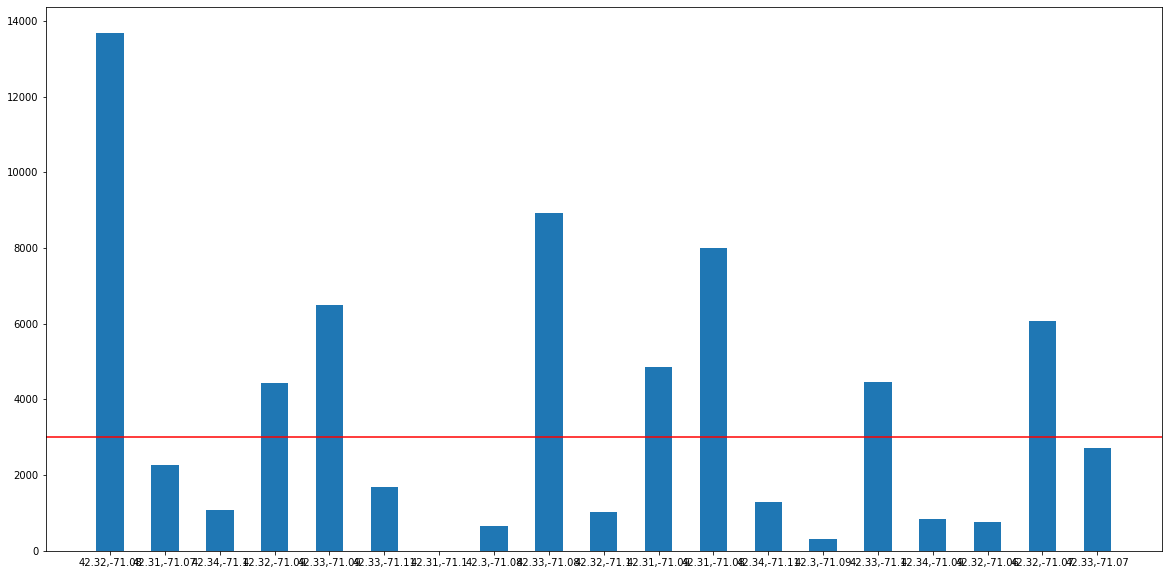

In [3]:
crime['gLat'] = crime[crime['DISTRICT'] == 'B2']['Lat'].apply(lambda x : str(round(x,2)))
crime['gLong'] = crime[crime['DISTRICT'] == 'B2']['Long'].apply(lambda x : str(round(x,2)))
crime['gloc'] = crime['gLat'] + ',' + crime['gLong']
count = crime['gloc'].value_counts(sort=False)

import matplotlib.pyplot as plt
%matplotlib inline
th = 3000
plt.figure(figsize=(20,10))
plt.axhline(y=th, color='red')
plt.bar(count.index,count.values, 0.5)
plt.show

We select the eight most highest crime locations, these will be the places for police to patrol.

- Find the eight most highest crime locations.

In [4]:
loc = []
n = 0
for i, c in enumerate(count):
    if c > 3000:
        n += 1
        loc.append(count.index[i])
loc = sorted(loc)
loc.insert(0, '42.328491,-71.085709') # location of police station
print(loc)

['42.328491,-71.085709', '42.31,-71.08', '42.31,-71.09', '42.32,-71.07', '42.32,-71.08', '42.32,-71.09', '42.33,-71.08', '42.33,-71.09', '42.33,-71.1']


All location can be found in this [link](https://www.google.com/maps/dir/42.3284910,+-71.0857090/'42.33,-71.08'/'42.32,-71.07'/'42.32,-71.08'/'42.31,-71.08'/42.31,-71.09%09/'42.32,-71.09'/'42.33,-71.1'/'42.33,-71.09'/42.3284910,+-71.0857090/@42.3215348,-71.097696,14.52z/data=!4m42!4m41!1m3!2m2!1d-71.085709!2d42.328491!1m3!2m2!1d-71.08!2d42.33!1m3!2m2!1d-71.07!2d42.32!1m3!2m2!1d-71.08!2d42.32!1m3!2m2!1d-71.08!2d42.31!1m3!2m2!1d-71.09!2d42.31!1m3!2m2!1d-71.09!2d42.32!1m3!2m2!1d-71.1!2d42.33!1m3!2m2!1d-71.09!2d42.33!1m3!2m2!1d-71.085709!2d42.328491!3e0)

### Linear Programming Formulations
we use Dantzig-Fulkerson-Johnson formulation for this case.
you can find more information in this [link](https://en.wikipedia.org/wiki/Travelling_salesman_problem)

Variables (image from wikipedia): 
![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/210952104494d8add3acf817d00c2a1be0c97a81 "Variables")
In out case, x is the path from location i to location j

Objective and constrain (image from wikipedia):
![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/6a905ac6dc7f1f81c901a8c3680e5951d273d21f "Opjective and constrain")
Where c is distance between location i to location j.<br/>
The last line is for making sure that there is no sub-route.

Then we need to find the distance between each location, we use google map to find the distances.

- Create the matrix of distances.

In [5]:
import numpy as np

nmap = pd.DataFrame()
nmap['loc'] = loc

for i in range(len(loc)):
    dist = []
    for j in range(len(loc)):
        x1 = float(loc[i].split(',')[0])
        y1 = float(loc[i].split(',')[1])
        x2 = float(loc[j].split(',')[0])
        y2 = float(loc[j].split(',')[1])
        dist.append(np.sqrt((x1-x2)**2 + (y1-y2)**2))
    nmap[str(i)] = pd.Series(dist).values
        
nmap

,loc,0,1,2,3,4,5,6,7,8
0,"42.328491,-71.085709",0.000000,0.019352,0.018982,0.017857,0.010232,0.009514,0.005905,0.004549,0.014370
1,"42.31,-71.08",0.019352,0.000000,0.010000,0.014142,0.010000,0.014142,0.020000,0.022361,0.028284
2,"42.31,-71.09",0.018982,0.010000,0.000000,0.022361,0.014142,0.010000,0.022361,0.020000,0.022361
3,"42.32,-71.07",0.017857,0.014142,0.022361,0.000000,0.010000,0.020000,0.014142,0.022361,0.031623
4,"42.32,-71.08",0.010232,0.010000,0.014142,0.010000,0.000000,0.010000,0.010000,0.014142,0.022361
5,"42.32,-71.09",0.009514,0.014142,0.010000,0.020000,0.010000,0.000000,0.014142,0.010000,0.014142
6,"42.33,-71.08",0.005905,0.020000,0.022361,0.014142,0.010000,0.014142,0.000000,0.010000,0.020000
7,"42.33,-71.09",0.004549,0.022361,0.020000,0.022361,0.014142,0.010000,0.010000,0.000000,0.010000
8,"42.33,-71.1",0.014370,0.028284,0.022361,0.031623,0.022361,0.014142,0.020000,0.010000,0.000000


Note that 0 is the location of the police station.<br/>
Since we have only eight locations, the combination of all posible routes is 8! or 40,320.<br/>
This number is small, so we can use Exact algorithms to find the best route.

- Find the all possible route

In [6]:
from itertools import permutations

ways = list(permutations([1,2,3,4,5,6,7,8], 8))

for i in range(len(ways)):
    if i % 2000 == 0:
        print(ways[i])

(1, 2, 3, 4, 5, 6, 7, 8)
(1, 4, 7, 6, 3, 5, 2, 8)
(1, 7, 5, 3, 6, 8, 2, 4)
(2, 3, 5, 1, 4, 6, 7, 8)
(2, 6, 1, 7, 4, 5, 3, 8)
(2, 8, 7, 3, 5, 6, 1, 4)
(3, 4, 7, 1, 2, 5, 6, 8)
(3, 7, 4, 6, 2, 5, 1, 8)
(4, 2, 3, 5, 7, 8, 1, 6)
(4, 6, 1, 2, 3, 5, 7, 8)
(4, 8, 6, 5, 2, 3, 1, 7)
(5, 3, 6, 2, 7, 8, 1, 4)
(5, 7, 3, 1, 2, 4, 6, 8)
(6, 2, 1, 7, 4, 5, 3, 8)
(6, 4, 8, 2, 5, 7, 1, 3)
(6, 8, 5, 1, 2, 3, 4, 7)
(7, 3, 4, 6, 2, 5, 1, 8)
(7, 6, 2, 3, 5, 8, 1, 4)
(8, 2, 1, 3, 4, 5, 6, 7)
(8, 4, 6, 5, 2, 3, 1, 7)
(8, 7, 4, 2, 5, 6, 1, 3)


These are sample routes. 

We will go through all possible routes and calculate the distance of each route,<br/>
and save the route that has the minimum distance.

In [7]:
mindist = 1000
minway = ()
for way in ways:
    dist = 0
    # add distance from 0 to first node
    dist += nmap[str(way[0])][0]
    for i in range(7):
        dist += nmap[str(way[i+1])][way[i]]
    # add distance from last node to 0
    dist += nmap['0'][way[7]]
    if dist < mindist:
        mindist = dist
        minway = way
        
print('shortest path:', minway)
print('shortest distance:', mindist)

shortest path: (6, 3, 4, 1, 2, 5, 8, 7)
shortest distance: 0.08873793365626632
